In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras._tf_keras.keras.models import Model

from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [3]:
dataframe = pd.read_csv('ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


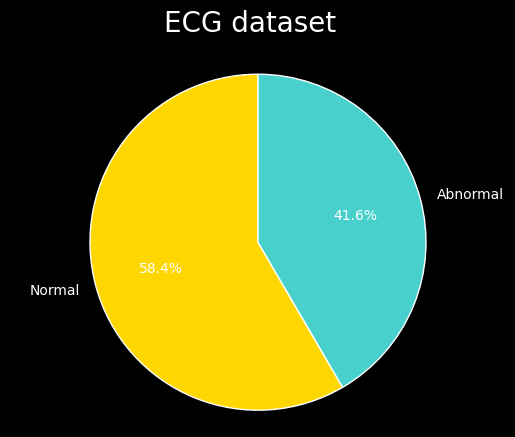

In [4]:
import matplotlib.pyplot as plt

# Assuming dataframe[140] contains 'Normal' and 'Abnormal' values
colors = ['gold', 'mediumturquoise']
labels = ['Normal', 'Abnormal']
values = dataframe[140].value_counts() / dataframe[140].shape[0]

# Create pie chart
fig, ax = plt.subplots()
ax.pie(
    values, 
    labels=labels, 
    colors=colors, 
    autopct='%1.1f%%', 
    startangle=90, 
    wedgeprops={'edgecolor': 'white'}
)

ax.axis('equal')  
fig.suptitle('ECG dataset', color='white', fontsize=20)
fig.patch.set_facecolor('black') 
ax.set_facecolor('black')  
plt.setp(ax.texts, color='white')
plt.show()


In [5]:
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [6]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [7]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

print("the length of train :",len(train_labels))
print("the length of test :",len(test_labels))

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

the length of train : 3998
the length of test : 1000


Text(0.5, 1.0, 'A Normal ECG')

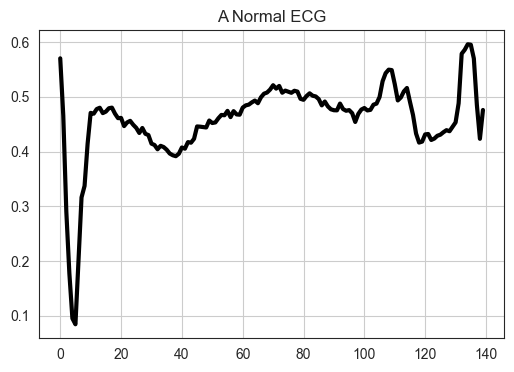

In [8]:
plt.figure(figsize=(6,4))
sns.set_style("white")
plt.grid()
plt.plot(np.arange(140), normal_train_data[0],color='black',linewidth=3.0)
plt.title("A Normal ECG")

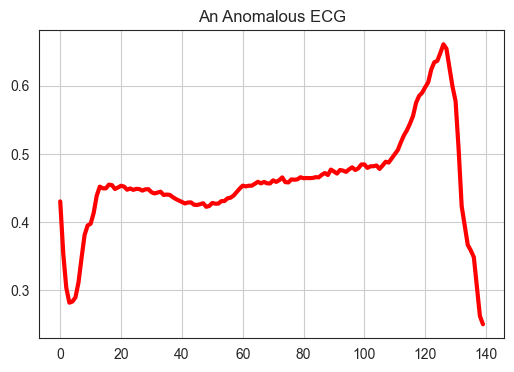

In [9]:
plt.figure(figsize=(6,4))
sns.set_style("white")
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0],color='red',linewidth=3.0)
plt.title("An Anomalous ECG")
plt.show()

In [10]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [11]:
autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])


In [33]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=25, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.1557 - loss: 5.2038e-04 - val_acc: 0.0930 - val_loss: 0.0021
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.1528 - loss: 5.0166e-04 - val_acc: 0.0940 - val_loss: 0.0021
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.1510 - loss: 5.2067e-04 - val_acc: 0.0980 - val_loss: 0.0021
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.1708 - loss: 5.1041e-04 - val_acc: 0.1080 - val_loss: 0.0021
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.1723 - loss: 5.0354e-04 - val_acc: 0.1000 - val_loss: 0.0021
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.1705 - loss: 5.1171e-04 - val_acc: 0.0950 - val_loss: 0.0021
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.1493 - loss: 5.1852e-04 - val_acc: 0.0980 - val_loss: 0.0021
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.1626 - loss: 5.0067e-04 - val_acc: 0.1010 - val_loss: 0.0021
Epoch 9/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

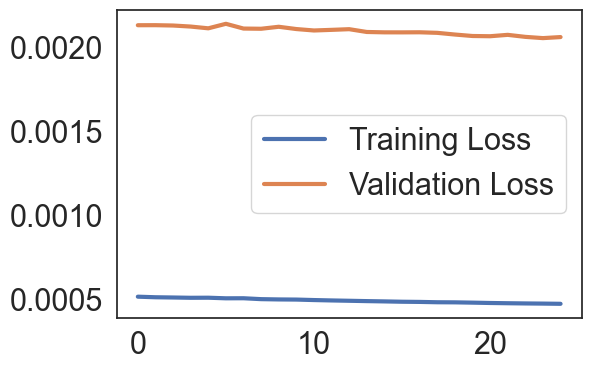

In [34]:
plt.figure(figsize=(6,4))
sns.set_style("white")
plt.plot(history.history["loss"], label="Training Loss",linewidth=3.0)
plt.plot(history.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.legend()

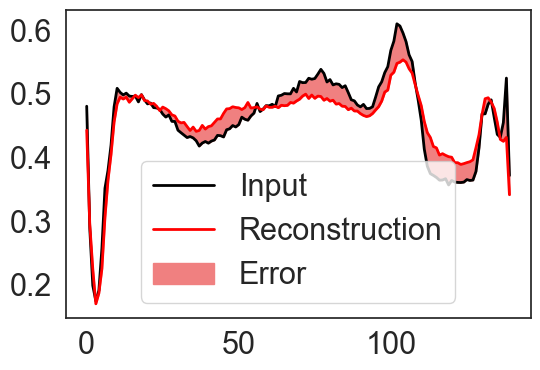

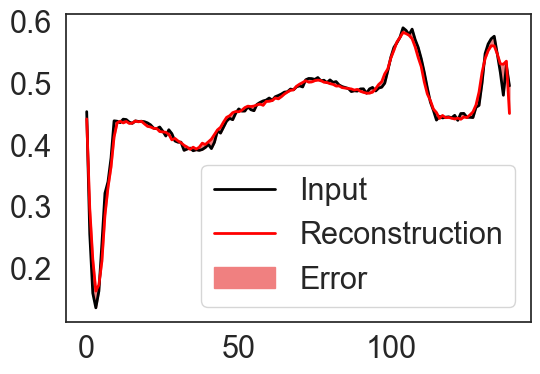

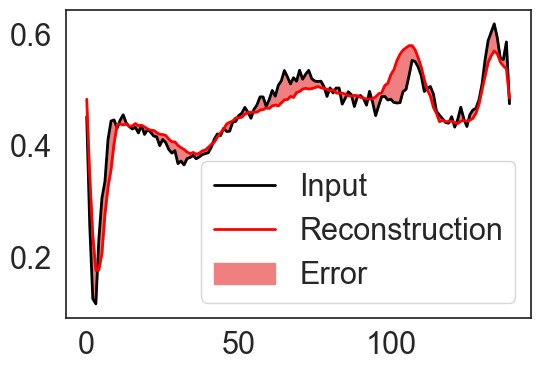

In [35]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

for i in range(0,3):
    plt.figure(figsize=(6,4))
    sns.set_style("white")
    plt.plot(normal_test_data[i], 'black',linewidth=2)
    plt.plot(decoded_imgs[i], 'red',linewidth=2)
    plt.fill_between(np.arange(140), decoded_imgs[i], normal_test_data[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()
    

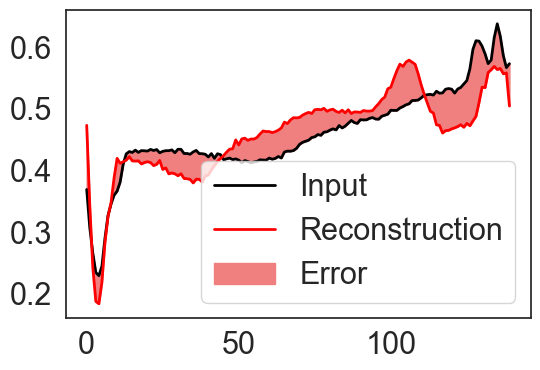

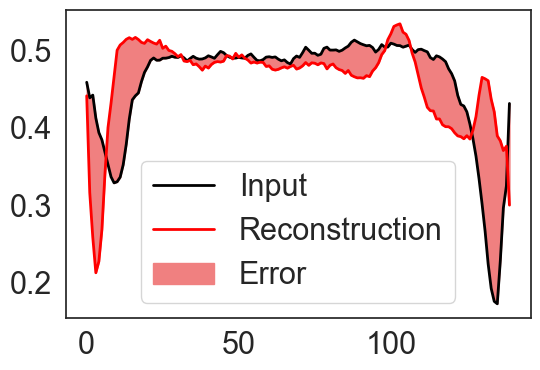

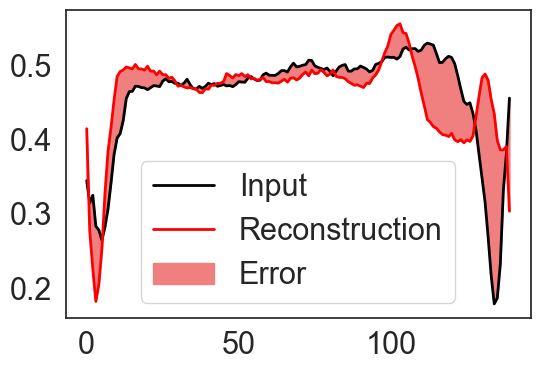

In [36]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

for i in range(0,3):
    plt.figure(figsize=(6,4))
    sns.set_style("white")
    plt.plot(anomalous_test_data[i], 'black',linewidth=2)
    plt.plot(decoded_imgs[i], 'red',linewidth=2)
    plt.fill_between(np.arange(140), decoded_imgs[i], anomalous_test_data[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()

In [37]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [38]:
np.mean(train_loss)

0.013298452

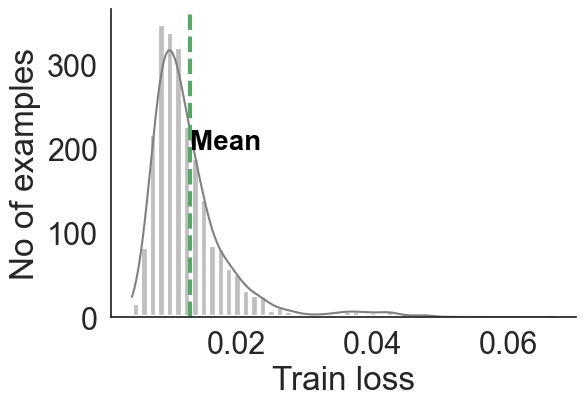

In [39]:
plt.figure(figsize=(6,4))
sns.histplot(train_loss ,bins=50,kde=True,color='grey',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Mean", horizontalalignment='left', 
         size='small', color='black', weight='semibold')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
sns.despine()

In [40]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.019769846


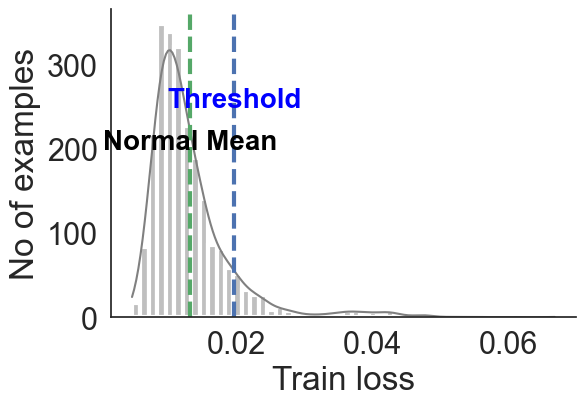

In [41]:
plt.figure(figsize=(6,4))
sns.histplot(train_loss ,bins=50,kde=True,color='grey',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Normal Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(threshold, 250, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
sns.despine()

In [42]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


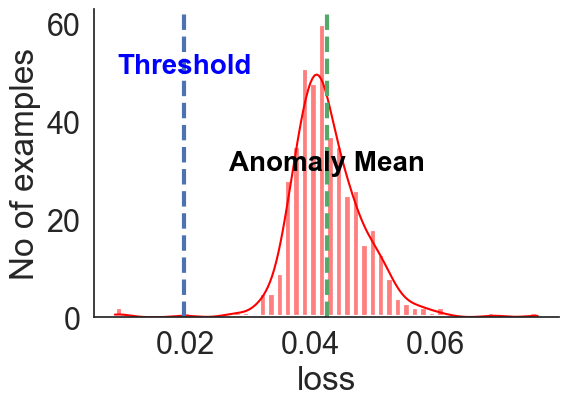

In [43]:
plt.figure(figsize=(6,4))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(test_loss ,bins=50,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(test_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 30, "Anomaly Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.text(threshold, 50, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.xlabel("loss")
plt.ylabel("No of examples")
sns.despine()

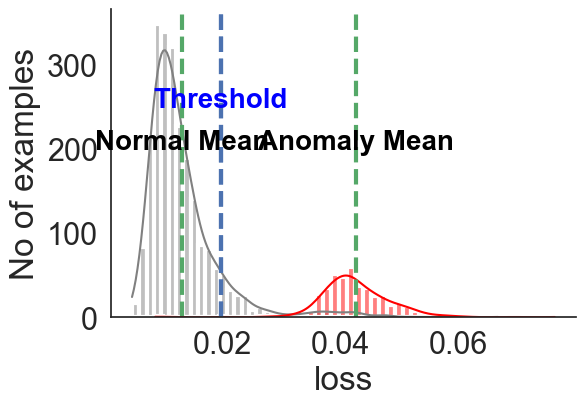

In [44]:
plt.figure(figsize=(6,4))
sns.histplot(train_loss ,bins=50,kde=True,color='grey',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Normal Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(threshold, 250, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')

sns.histplot(test_loss ,bins=50,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(test_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 200, "Anomaly Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.xlabel("loss")
plt.ylabel("No of examples")
sns.despine()


In [45]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy : {:.2f} %".format(accuracy_score(labels, preds)*100))


preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy : 94.40 %
